In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# NVTabular / HugeCTR Criteo Example 
Here we'll show how to use NVTabular first as a preprocessing library to prepare the [Criteo Display Advertising Challenge](https://www.kaggle.com/c/criteo-display-ad-challenge) dataset, and then train a model using HugeCTR.

### Data Prep
Before we get started, make sure you've run the [optimize_criteo notebook](../optimize_criteo.ipynb), which will convert the tsv data published by Criteo into the parquet format that our accelerated readers prefer. It's fair to mention at this point that that notebook will take ~30 minutes to run. While we're hoping to release accelerated csv readers in the near future, we also believe that inefficiencies in existing data representations like csv are in no small part a consequence of inefficiencies in the existing hardware/software stack. Accelerating these pipelines on new hardware like GPUs may require us to make new choices about the representations we use to store that data, and parquet represents a strong alternative.

In [1]:
# Standard Libraries
import os
from time import time
import re
import shutil
import glob
import warnings

# External Dependencies
import numpy as np
import cupy as cp
import cudf
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from dask.utils import parse_bytes
from dask.delayed import delayed
import rmm

# NVTabular
import nvtabular as nvt
from nvtabular.ops import Categorify, Clip, FillMissing, HashBucket, LambdaOp, LogOp, Rename, get_embedding_sizes
from nvtabular.io import Shuffle
from nvtabular.utils import _pynvml_mem_size, device_mem_size

# HugeCTR
import sys
sys.path.append("/usr/local/hugectr/lib")
from hugectr import Session, solver_parser_helper, get_learning_rate_scheduler

### Dataset and Dataset Schema
Once our data is ready, we'll define some high level parameters to describe where our data is and what it "looks like" at a high level.

In [3]:
# define some information about where to get our data
BASE_DIR = "/raid/criteo/tests/"
input_path = os.path.join(BASE_DIR, "crit_int_pq")
dask_workdir = os.path.join(BASE_DIR, "test_dask/workdir")
output_path = os.path.join(BASE_DIR, "test_dask/output")
stats_path = os.path.join(BASE_DIR, "test_dask/stats")

NUM_TRAIN_DAYS = 23 # number of days worth of data to use for training, the rest will be used for validation

# Make sure we have a clean worker space for Dask
if os.path.isdir(dask_workdir):
    shutil.rmtree(dask_workdir)
os.makedirs(dask_workdir)

# Make sure we have a clean stats space for Dask
if os.path.isdir(stats_path):
    shutil.rmtree(stats_path)
os.mkdir(stats_path)
         
# Make sure we have a clean output path
if os.path.isdir(output_path):
    shutil.rmtree(output_path)
os.mkdir(output_path)

In [4]:
! ls $BASE_DIR

crit_int_pq  example.parquet  output  test_dask


In [5]:
fname = 'day_{}.parquet'
num_days = len([i for i in os.listdir(input_path) if re.match(fname.format('[0-9]{1,2}'), i) is not None])
train_paths = [os.path.join(input_path, fname.format(day)) for day in range(NUM_TRAIN_DAYS)]
valid_paths = [os.path.join(input_path, fname.format(day)) for day in range(NUM_TRAIN_DAYS, num_days)]
print(train_paths)
print(valid_paths)

['/raid/criteo/tests/crit_int_pq/day_0.parquet', '/raid/criteo/tests/crit_int_pq/day_1.parquet', '/raid/criteo/tests/crit_int_pq/day_2.parquet', '/raid/criteo/tests/crit_int_pq/day_3.parquet', '/raid/criteo/tests/crit_int_pq/day_4.parquet', '/raid/criteo/tests/crit_int_pq/day_5.parquet', '/raid/criteo/tests/crit_int_pq/day_6.parquet', '/raid/criteo/tests/crit_int_pq/day_7.parquet', '/raid/criteo/tests/crit_int_pq/day_8.parquet', '/raid/criteo/tests/crit_int_pq/day_9.parquet', '/raid/criteo/tests/crit_int_pq/day_10.parquet', '/raid/criteo/tests/crit_int_pq/day_11.parquet', '/raid/criteo/tests/crit_int_pq/day_12.parquet', '/raid/criteo/tests/crit_int_pq/day_13.parquet', '/raid/criteo/tests/crit_int_pq/day_14.parquet', '/raid/criteo/tests/crit_int_pq/day_15.parquet', '/raid/criteo/tests/crit_int_pq/day_16.parquet', '/raid/criteo/tests/crit_int_pq/day_17.parquet', '/raid/criteo/tests/crit_int_pq/day_18.parquet', '/raid/criteo/tests/crit_int_pq/day_19.parquet', '/raid/criteo/tests/crit_int_

### Deploy a Distributed-Dask Cluster

In [6]:
# Dask dashboard
dashboard_port = "8787"

# Deploy a Single-Machine Multi-GPU Cluster
protocol = "tcp"             # "tcp" or "ucx"
NUM_GPUS = [0,1,2,3]
visible_devices = ",".join([str(n) for n in NUM_GPUS])  # Delect devices to place workers
device_limit_frac = 0.4      # Spill GPU-Worker memory to host at this limit.
device_pool_frac = 0.5
part_mem_frac = 0.1

# Use total device size to calculate args.device_limit_frac
device_size = device_mem_size(kind="total")
device_limit = int(device_limit_frac * device_size)
device_pool_size = int(device_pool_frac * device_size)
part_size = int(part_mem_frac * device_size)

# Check if any device memory is already occupied
for dev in visible_devices.split(","):
    fmem = _pynvml_mem_size(kind="free", index=int(dev))
    used = (device_size - fmem) / 1e9
    if used > 1.0:
        warnings.warn(f"BEWARE - {used} GB is already occupied on device {int(dev)}!")

cluster = None               # (Optional) Specify existing scheduler port
if cluster is None:
    cluster = LocalCUDACluster(
        protocol = protocol,
        n_workers=len(visible_devices.split(",")),
        CUDA_VISIBLE_DEVICES = visible_devices,
        device_memory_limit = device_limit,
        local_directory=dask_workdir,
        dashboard_address=":" + dashboard_port,
    )

# Create the distributed client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45915 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 1.20 TB


#### Initilize Memory Pools

In [7]:
# Initialize RMM pool on ALL workers
def _rmm_pool():
    rmm.reinitialize(
        # RMM may require the pool size to be a multiple of 256.
        pool_allocator=True,
        initial_pool_size=(device_pool_size // 256) * 256, # Use default size
    )
    
client.run(_rmm_pool)

{'tcp://127.0.0.1:35723': None,
 'tcp://127.0.0.1:37491': None,
 'tcp://127.0.0.1:38021': None,
 'tcp://127.0.0.1:41279': None,
 'tcp://127.0.0.1:42669': None,
 'tcp://127.0.0.1:42905': None,
 'tcp://127.0.0.1:44597': None,
 'tcp://127.0.0.1:46049': None}

### Preprocessing
At this point, our data still isn't in a form that's ideal for consumption by neural networks. The most pressing issues are missing values and the fact that our categorical variables are still represented by random, discrete identifiers, and need to be transformed into contiguous indices that can be leveraged by a learned embedding. Less pressing, but still important for learning dynamics, are the distributions of our continuous variables, which are distributed across multiple orders of magnitude and are uncentered (i.e. E[x] != 0).

We can fix these issues in a conscise and GPU-accelerated manner with an NVTabular `Workflow`. We'll instantiate one with our current dataset schema, then symbolically add operations _on_ that schema. By setting all these `Ops` to use `replace=True`, the schema itself will remain unmodified, while the variables represented by each field in the schema will be transformed.

#### Frequency Thresholding
One interesting thing worth pointing out is that we're using _frequency thresholding_ in our `Categorify` op. This handy functionality will map all categories which occur in the dataset with some threshold level of infrequency (which we've set here to be 15 occurrences throughout the dataset) to the _same_ index, keeping the model from overfitting to sparse signals.

In [8]:
# define our dataset schema
CONTINUOUS_COLUMNS = ['I' + str(x) for x in range(1,14)]
CATEGORICAL_COLUMNS =  ['C' + str(x) for x in range(1,27)]
LABEL_COLUMNS = ['label']
COLUMNS = CONTINUOUS_COLUMNS + CATEGORICAL_COLUMNS + LABEL_COLUMNS

num_buckets = 10000000
categorify_op = Categorify(out_path=stats_path)
cat_features = CATEGORICAL_COLUMNS >> categorify_op >> (lambda col: col % num_buckets)
cont_features = CONTINUOUS_COLUMNS >> FillMissing() >> Clip(min_value=0)
features = cat_features + cont_features + LABEL_COLUMNS

workflow = nvt.Workflow(features)

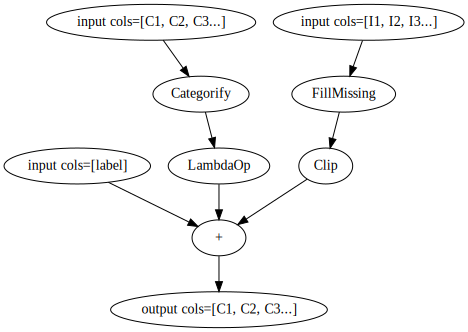

In [9]:
features.graph

Now instantiate dataset iterators to loop through our dataset (which we couldn't fit into GPU memory). We need to enforce the required HugeCTR data types, so we set them in a dictionary and give as an argument when creating our dataset

In [10]:
dict_dtypes={}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64
    
for col in CONTINUOUS_COLUMNS:
    dict_dtypes[col] = np.float32
    
for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [11]:
train_dataset = nvt.Dataset(train_paths, engine='parquet', part_size=part_size)
valid_dataset = nvt.Dataset(valid_paths, engine='parquet', part_size=part_size)

Now run them through our workflows to collect statistics on the train set, then transform and save to parquet files.

In [12]:
output_train_dir = os.path.join(output_path, 'train/')
output_valid_dir = os.path.join(output_path, 'valid/')
! mkdir -p $output_train_dir
! mkdir -p $output_valid_dir

For reference, let's time it to see how long it takes...

In [13]:
%%time
workflow.fit(train_dataset)

CPU times: user 7min 42s, sys: 10min 5s, total: 17min 48s
Wall time: 40min 9s


In [14]:
%%time
workflow.transform(train_dataset).to_parquet(output_path=output_train_dir,
                                         shuffle=nvt.io.Shuffle.PER_PARTITION, 
                                         dtypes=dict_dtypes,
                                         cats=CATEGORICAL_COLUMNS,
                                         conts=CONTINUOUS_COLUMNS,
                                         labels=LABEL_COLUMNS)

CPU times: user 7min 53s, sys: 18min 8s, total: 26min 2s
Wall time: 25min 35s


In [15]:
%%time
workflow.transform(valid_dataset).to_parquet(output_path=output_valid_dir, 
                                             dtypes=dict_dtypes,
                                             cats=CATEGORICAL_COLUMNS,
                                             conts=CONTINUOUS_COLUMNS,
                                             labels=LABEL_COLUMNS)

CPU times: user 29.1 s, sys: 54.9 s, total: 1min 24s
Wall time: 2min 46s


Get the embeddings table size, to configurate `slot_size_array` in `dlrm_fp32_64k.json`

In [16]:
embeddings = [c[0] for c in categorify_op.get_embedding_sizes(CATEGORICAL_COLUMNS).values()]
embeddings = np.clip(a=embeddings, a_min=None, a_max=num_buckets).tolist()
print(embeddings)

[10000000, 10000000, 3014529, 400781, 11, 2209, 11869, 148, 4, 977, 15, 38713, 10000000, 10000000, 10000000, 584616, 12883, 109, 37, 17177, 7425, 20266, 4, 7085, 1535, 64]


And just like that, we have training and validation sets ready to feed to a model!

## HugeCTR
### Training
We'll run huge_ctr using the DLRM configuration file.

First, we'll shutdown our Dask client from earlier to free up some memory so that we can share it with HugeCTR.

In [17]:
client.shutdown()
cluster.close()

Finally, we run HugeCTR. For reference, let's time it to see how long it takes...

In [ ]:
solver = hugectr.solver_parser_helper(num_epochs = 0,
                                    max_iter = 10000,
                                    max_eval_batches = 100,
                                    batchsize_eval = 2720,
                                    batchsize = 2720,
                                    display = 1000,
                                    eval_interval = 3200,
                                    i64_input_key = True,
                                    use_mixed_precision = False,
                                    repeat_dataset = True)
optimizer = hugectr.optimizer.CreateOptimizer(optimizer_type = hugectr.Optimizer_t.SGD,
                                    use_mixed_precision = False)
model = hugectr.Model(solver, optimizer)
model.add(hugectr.Input(data_reader_type = hugectr.DataReaderType_t.Parquet,
                            source = "/raid/criteo/tests/test_dask/output/train/_file_list.txt",
                            eval_source = "/raid/criteo/tests/test_dask/output/valid/_file_list.txt",
                            check_type = hugectr.Check_t.Non,
                            label_dim = 1, label_name = "label",
                            dense_dim = 13, dense_name = "dense",
                            slot_size_array = [10000000, 10000000, 3014529, 400781, 11, 2209, 11869, 148, 4, 977, 15, 38713, 10000000, 10000000, 10000000, 584616, 12883, 109, 37, 17177, 7425, 20266, 4, 7085, 1535, 64],
                            data_reader_sparse_param_array = 
                            [hugectr.DataReaderSparseParam(hugectr.DataReaderSparse_t.Distributed, 30, 1, 26)],
                            sparse_names = ["data1"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["dense"],
                            top_names = ["fc1"],
                            num_output=512))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc1"],
                            top_names = ["relu1"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu1"],
                            top_names = ["fc2"],
                            num_output=256))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc2"],
                            top_names = ["relu2"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu2"],
                            top_names = ["fc3"],
                            num_output=128))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc3"],
                            top_names = ["relu3"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.Interaction,
                            bottom_names = ["fc3", "sparse_embedding1"],
                            top_names = ["interaction1"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["interaction1"],
                            top_names = ["fc4"],
                            num_output=1024))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc4"],
                            top_names = ["relu4"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu4"],
                            top_names = ["fc5"],
                            num_output=1024))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc5"],
                            top_names = ["relu5"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu5"],
                            top_names = ["fc6"],
                            num_output=512))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc6"],
                            top_names = ["relu6"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu6"],
                            top_names = ["fc7"],
                            num_output=256))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.ReLU,
                            bottom_names = ["fc7"],
                            top_names = ["relu7"]))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.InnerProduct,
                            bottom_names = ["relu7"],
                            top_names = ["fc8"],
                            num_output=1))
model.add(hugectr.DenseLayer(layer_type = hugectr.Layer_t.BinaryCrossEntropyLoss,
                            bottom_names = ["fc8", "label"],
                            top_names = ["loss"]))
model.compile()
model.summary()
model.fit()